In [21]:
%load_ext autoreload
%autoreload 2

In [22]:
import pickle
import glob
import re
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import rc
rc('text', usetex=False)

In [23]:
with open('../expts/data/htpdata/solubility.pkl', 'rb') as handle:
    data = pickle.load(handle)
X_emb = np.load('../figures/notebooks/hte_tsne_Xembed.npy')


In [24]:
images_dir = '../figures/hteplots/*.png'
images_list = sorted([file for file in glob.glob(images_dir)])
print('Total of {} phase diagrams'.format(len(images_list)))

tagger = re.compile('../figures/hteplots/(.*)_(.*)_(.*).png')

tags_list = []
for img in images_list:
    tag = tagger.findall(img)
    tags_list.append(tag[0])
    
df_tags = pd.DataFrame(tags_list, columns=['solvent','small molecule','polymer'])

Total of 1720 phase diagrams


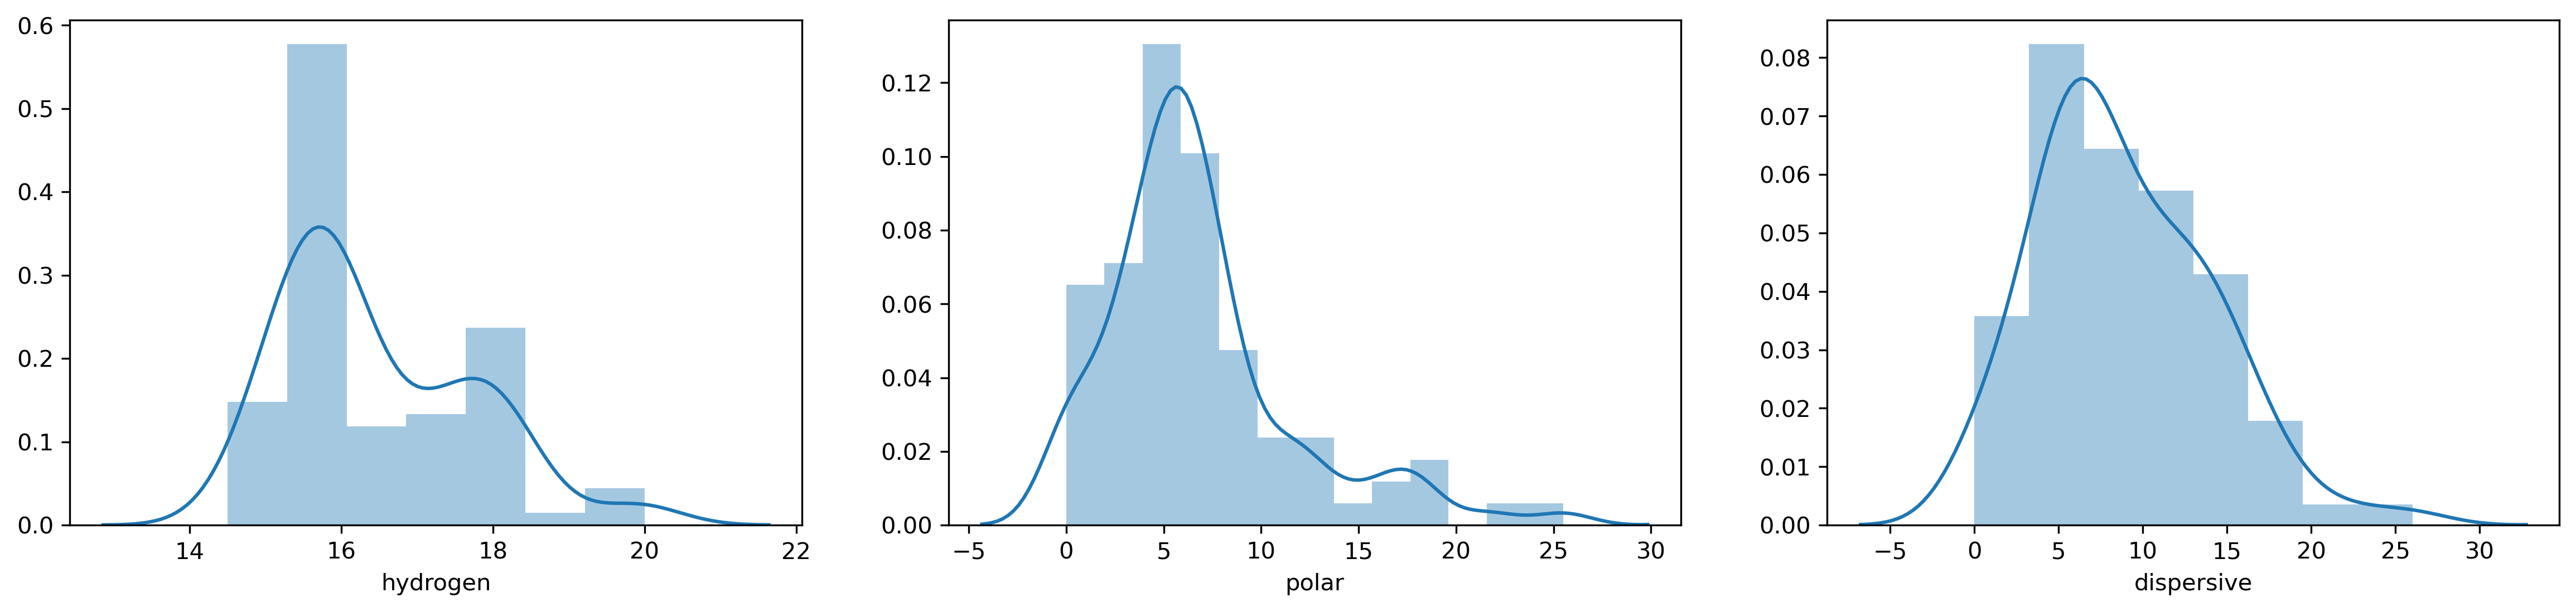

In [25]:
fig, axs = plt.subplots(1,3, figsize=(4*3*1.6, 4), dpi=300)
sns.distplot(data['solvents'].hydrogen, ax=axs[0])
sns.distplot(data['solvents'].polar, ax=axs[1])
sns.distplot(data['solvents'].dispersive, ax=axs[2])
plt.show()

In [26]:
df_tags['solv_h'] = df_tags['solvent'].apply(lambda x: data['solvents'].hydrogen[int(x)])
df_tags['solv_p'] = df_tags['solvent'].apply(lambda x: data['solvents'].polar[int(x)])
df_tags['solv_d'] = df_tags['solvent'].apply(lambda x: data['solvents'].dispersive[int(x)])
df_tags['tsne_x'] = X_emb[:,0]
df_tags['tsne_y'] = X_emb[:,1]
df_tags.head()

,solvent,small molecule,polymer,solv_h,solv_p,solv_d,tsne_x,tsne_y
0,0,DPP(PhTT)2,MDMO-PPV,15.5,10.4,7.0,-4.985990,11.262541
1,0,DPP(PhTT)2,MEH-PPV,15.5,10.4,7.0,-5.583282,11.735955
2,0,DPP(PhTT)2,P3HT,15.5,10.4,7.0,10.361498,25.491325
3,0,DPP(PhTT)2,PFO,15.5,10.4,7.0,-35.315708,-0.613992
4,0,DPP(TBFu)2,MDMO-PPV,15.5,10.4,7.0,-11.915854,4.606750


It appears that solvents with `polar` component >20 are placed closer than to solvents with ~(0-5). Most of the solvents have `hydrophobic` component near ~(16-18) and are generally spread across and does not show any interesting trends.
`dispersive` component also shows similar behavior : everything below 20 is seperated more or less

In [27]:
from polyphase import get_chi_vector
import pickle

with open('../expts/data/htpdata/solubility.pkl', 'rb') as handle:
    data = pickle.load(handle)

In [28]:
data['small molecules']

,index,name,dispersive,polar,hydrogen,R0,RED (PC61BM)
0,1,PC61BM,19.89,5.68,3.64,6.6,0.00
1,2,PC71BM,20.16,5.37,4.49,7.0,0.15
2,3,DPP(TBFu)2,19.33,4.78,6.26,5.1,0.59
3,4,F8-NODIPS,18.48,2.62,3.24,8.1,0.52
4,5,DPP(PhTT)2,19.64,3.54,6.12,–,–


In [29]:
import pdb

def add_chi_columns(row):
    solvent, polymer, sm = int(row['solvent']),row['polymer'], row['small molecule']
    delta_solvent = data['solvents'].loc[solvent].tolist()
    delta_sm = data['small molecules'].loc[data['small molecules']['name']==sm].values[0][2:5].tolist()
    delta_polymer = data['polymers'].loc[data['polymers']['name']==polymer].values[0][2:5].tolist()
    chi = get_chi_vector([delta_polymer,delta_sm,delta_solvent], 100, 2)[0]
    
    return pd.Series(chi, index=['chi 12','chi 13', 'chi 23'])

add_chi_columns(df_tags.loc[0])

chi 12    0.555223
chi 13    1.882709
chi 23    2.944843
dtype: float64

In [30]:
df_chis = df_tags.apply(add_chi_columns, axis=1)
df_tags = pd.concat([df_tags, df_chis], axis=1)

In [31]:
df_tags.head()

,solvent,small molecule,polymer,solv_h,solv_p,solv_d,tsne_x,tsne_y,chi 12,chi 13,chi 23
0,0,DPP(PhTT)2,MDMO-PPV,15.5,10.4,7.0,-4.985990,11.262541,0.555223,1.882709,2.944843
1,0,DPP(PhTT)2,MEH-PPV,15.5,10.4,7.0,-5.583282,11.735955,0.507756,1.955963,2.944843
2,0,DPP(PhTT)2,P3HT,15.5,10.4,7.0,10.361498,25.491325,0.748401,3.564506,2.944843
3,0,DPP(PhTT)2,PFO,15.5,10.4,7.0,-35.315708,-0.613992,0.513505,3.277155,2.944843
4,0,DPP(TBFu)2,MDMO-PPV,15.5,10.4,7.0,-11.915854,4.606750,0.409714,1.882709,2.216285


In [32]:
df_tags['solv_t'] = df_tags.apply(lambda x: np.linalg.norm(x.iloc[3:6]), axis=1)

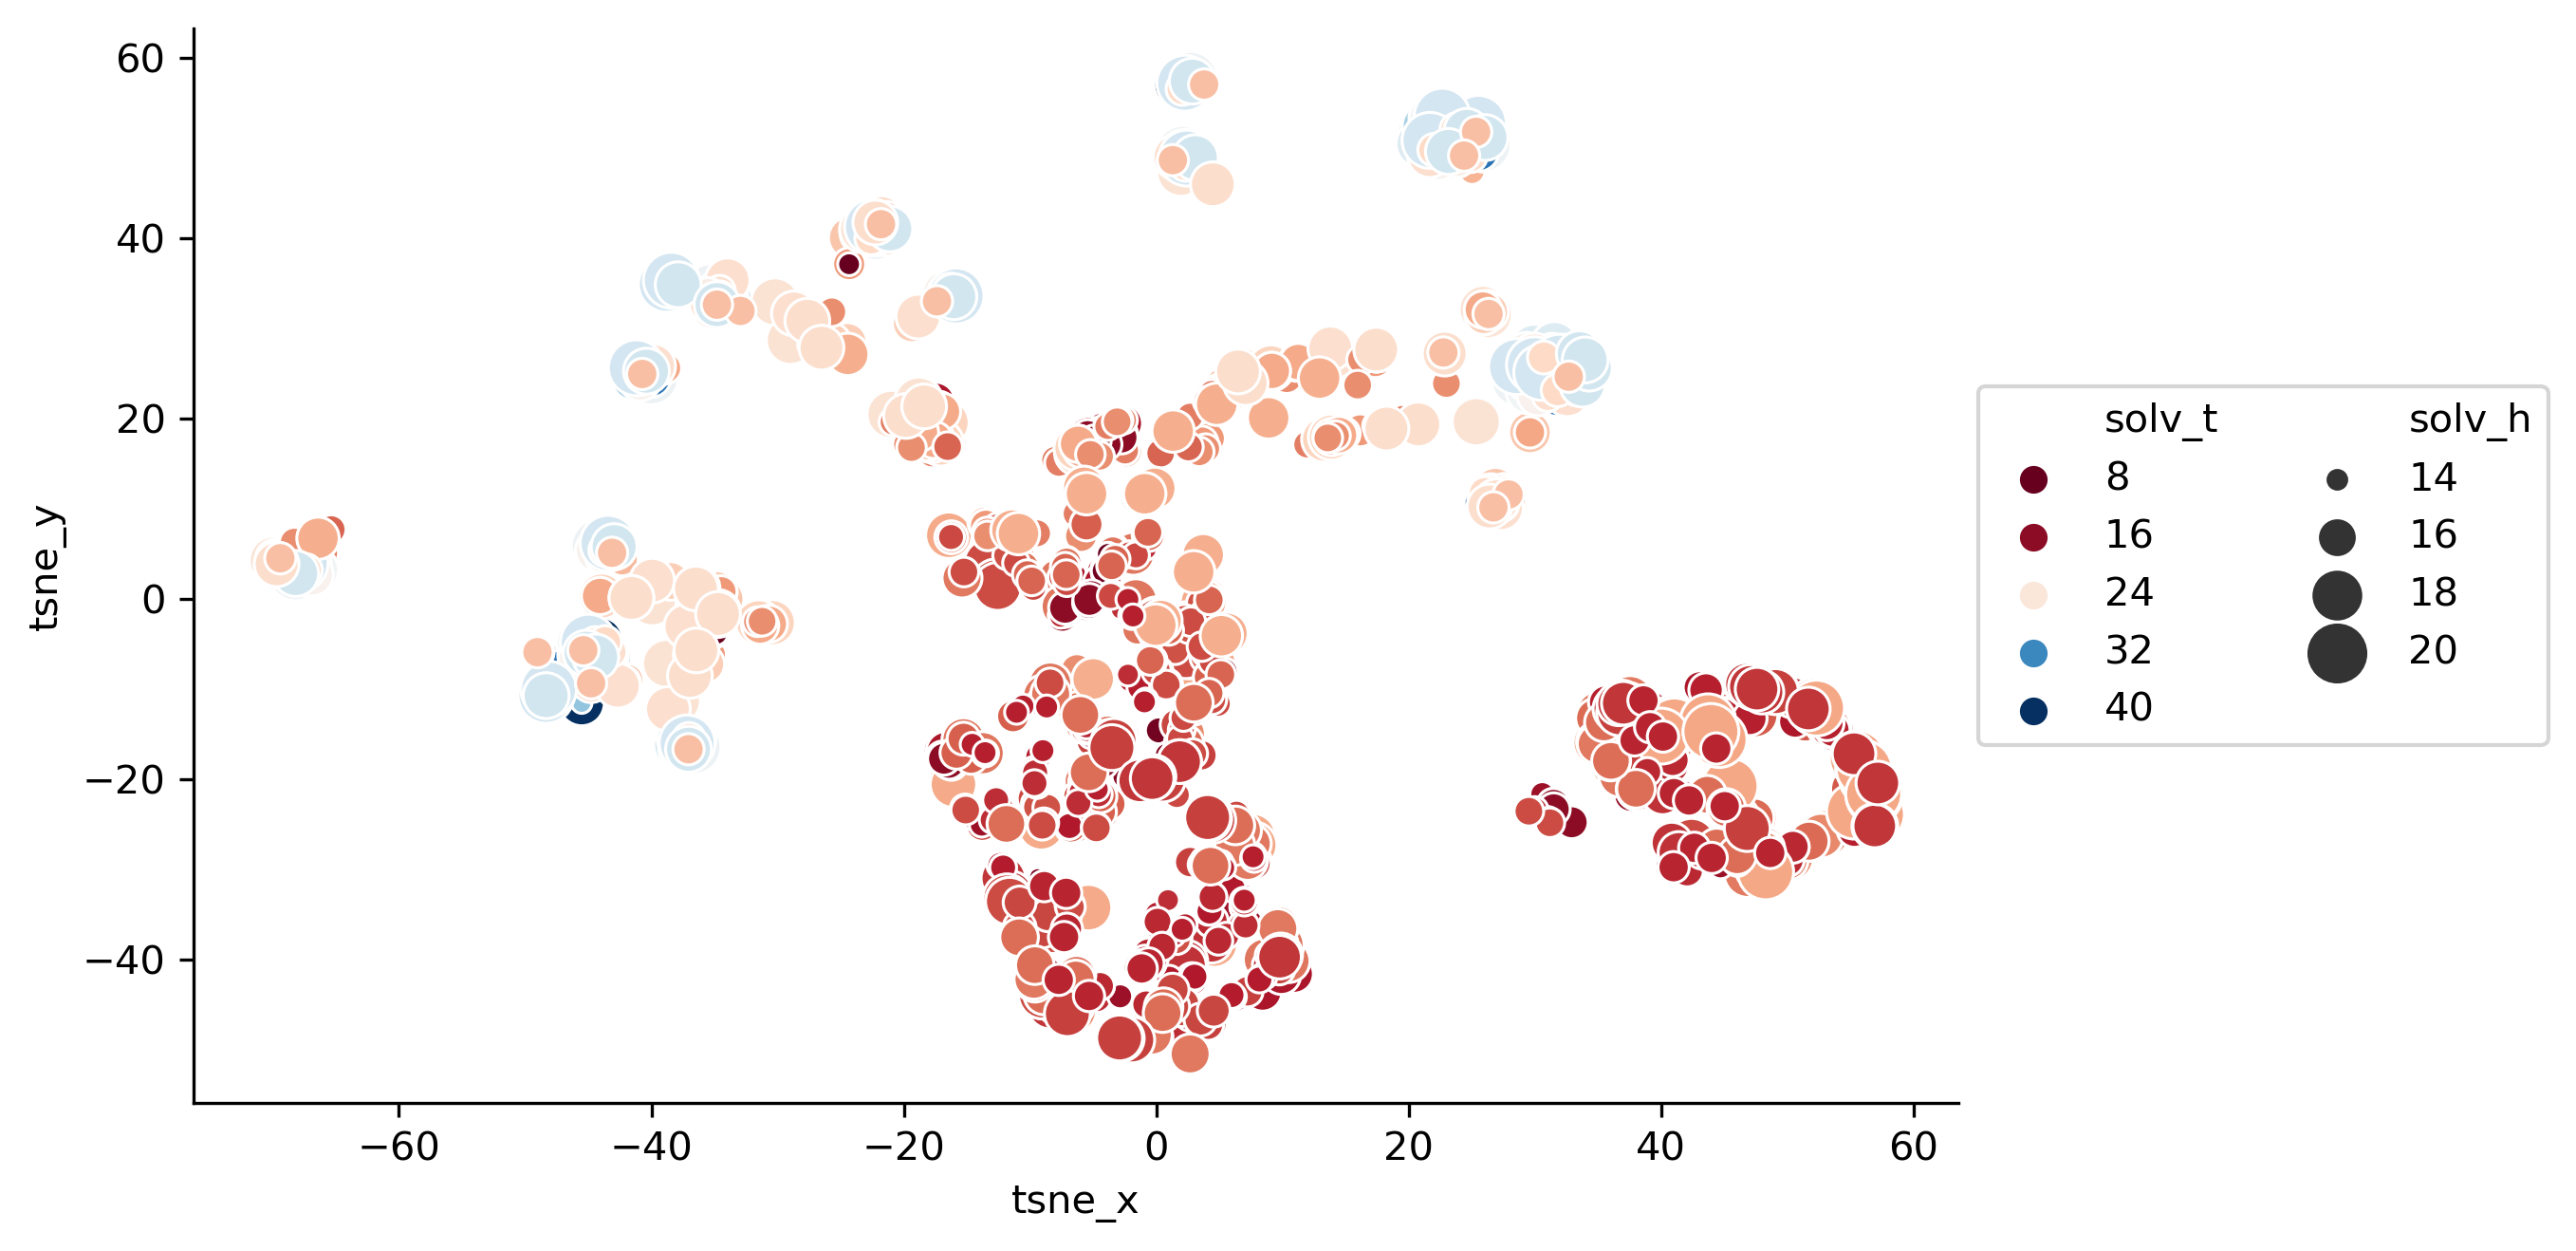

In [33]:
# look at how the tsne plot embeds the solubility parameters of solvent
fig, ax = plt.subplots(figsize=(5*1.6, 5),dpi=300)
ax = sns.scatterplot(x='tsne_x', y= 'tsne_y', size='solv_h', hue='solv_t',
                     sizes=(20, 200), data=df_tags, ax=ax, palette="RdBu"
)
sns.despine()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2)
plt.show()

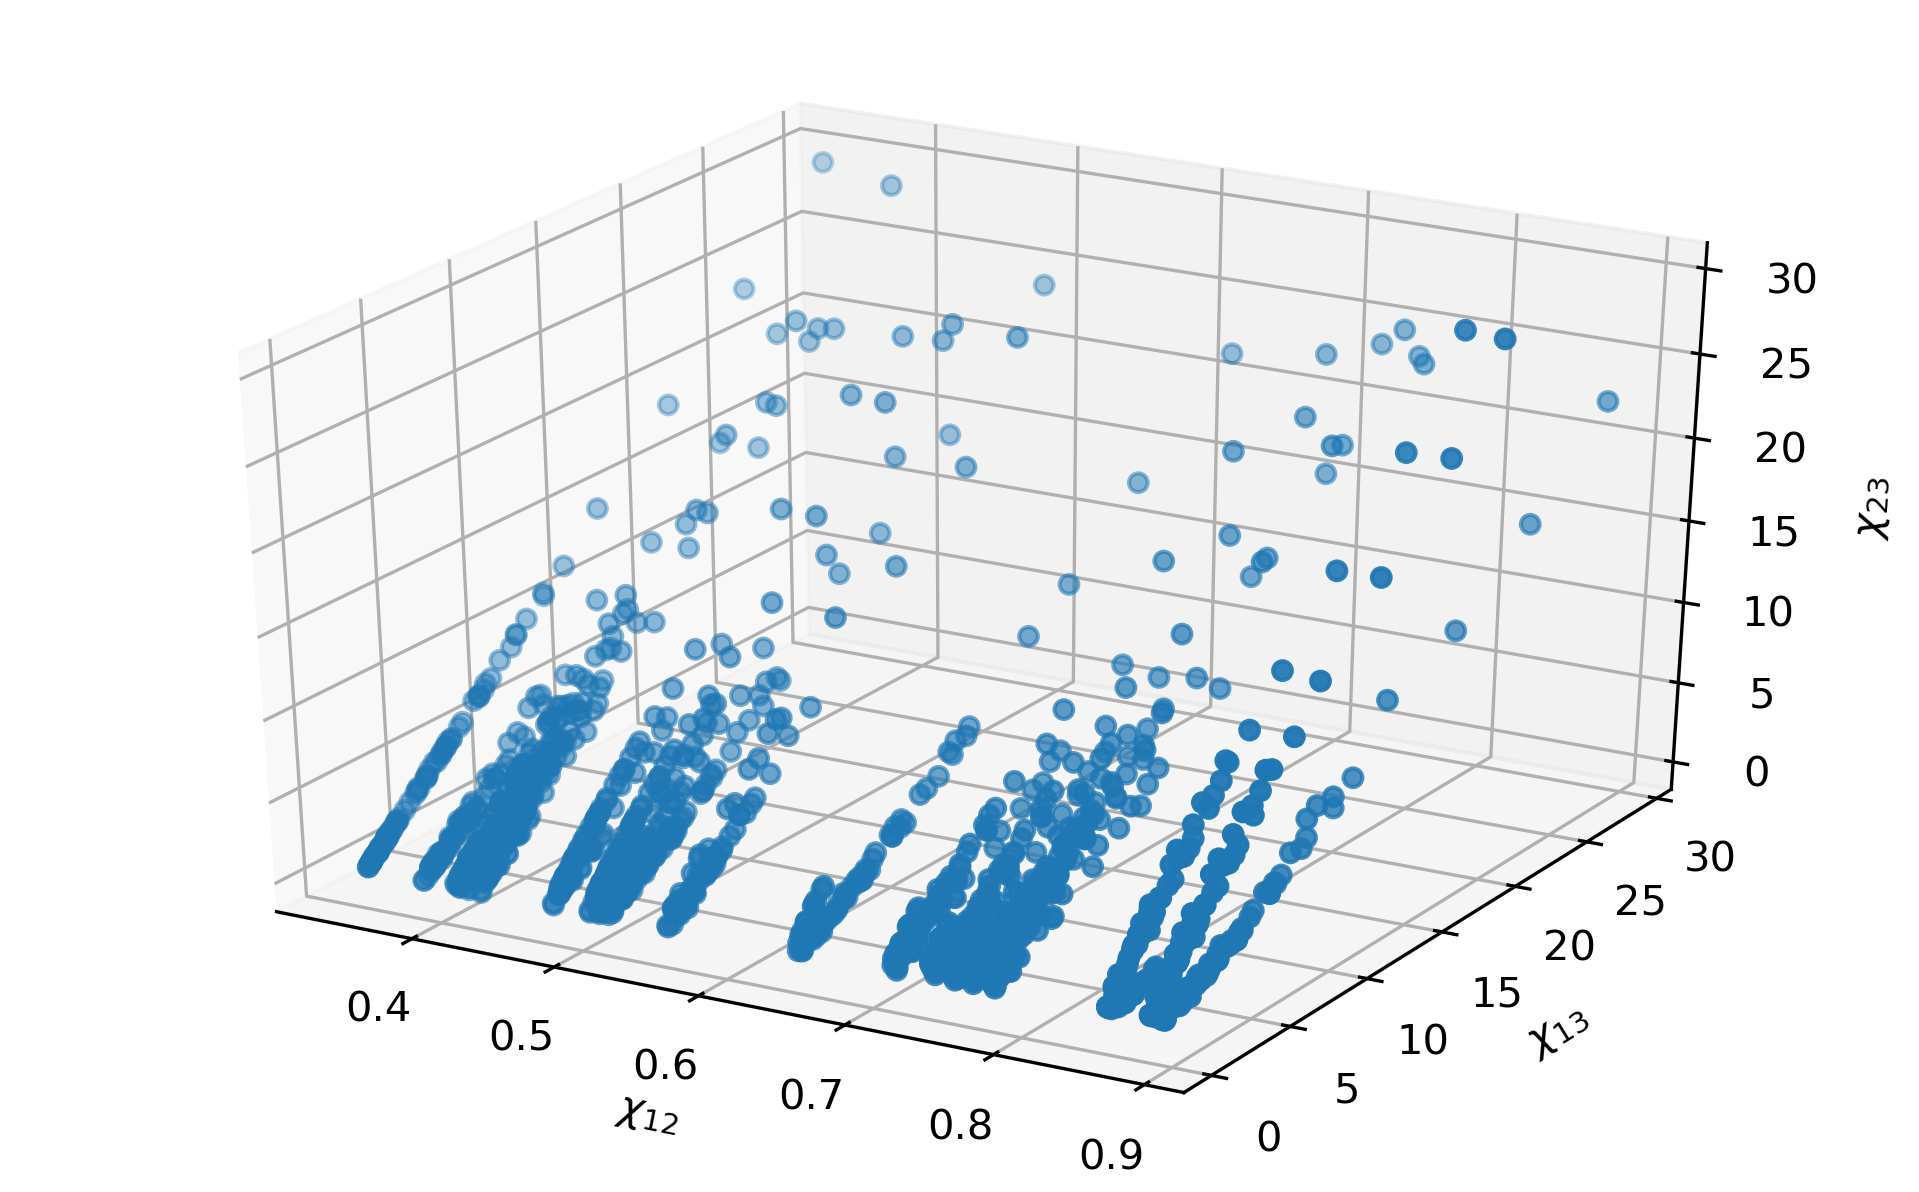

In [34]:
fig = plt.figure(figsize=(5*1.6, 5), dpi=300)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_tags['chi 12'], df_tags['chi 13'], df_tags['chi 23'])

ax.set_xlabel(r'$\chi_{12}$')
ax.set_ylabel(r'$\chi_{13}$')
ax.set_zlabel(r'$\chi_{23}$')
plt.show()

## Plot triangualated surfaces

We see a three phase regions in the phase diagram which means there's a big triangle connecting the three corners. But we still want to look at the expensive way of plotting energy surface as a triangulation in a interactive fashion and verify that !!!!

In [35]:
# pick a system with three phase region from the 1720 phase diagrams. Its actually the very first one
from polyphase import compute

chi = df_tags.iloc[0,-3:].to_list()
kwargs = {'flag_lift_label': True, 
          'use_weighted_delaunay': False,
          'flag_remove_collinear' : False, 
          'beta':1e-4, 
          'flag_make_energy_paraboloid': True, 
          'flag_lift_purecomp_energy': False}
configuration = {'M':[100,5,1], 'chi':chi}
dx=200
outdict = compute(3, configuration,dx, **kwargs)

2020-08-21 00:26:41,795	INFO resource_spec.py:212 -- Starting Ray with 35.5 GiB memory available for workers and up to 17.76 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-08-21 00:26:42,118	WARNING services.py:923 -- Redis failed to start, retrying now.
2020-08-21 00:26:44,502	INFO services.py:1165 -- View the Ray dashboard at localhost:8265


3-dimensional grid generated at 0.25s
Energy computed at 1.33s
Making energy manifold a paraboloid with 2x padding of 4.62 maximum energy
Energy is corrected at 15.72s
Convexhull is computed at 15.73s
Using 2.63E-02 as a threshold for Laplacian of a simplex
Total of 9 simplices in the convex hull
Simplices are labelled at 18.53s
Labels are lifted at 18.55s
Total 0/9 coplanar simplices
Computation took 18.55s


In [36]:
from polyphase import plot_triangulated_surface

fname = '_'.join(i for i in df_tags.iloc[0,:3])
x, y, z = outdict['grid'][0,:], outdict['grid'][1,:], outdict['energy']
fig = plot_triangulated_surface(x,y, x,y,z)
fig.update_layout(title=fname, scene=dict(
    xaxis_title="Phi_1",
    yaxis_title="Phi_2",
    zaxis_title = "Energy"),
    coloraxis_colorbar=dict(title='Energy'),
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="RebeccaPurple")
)
fig.write_html('../figures/3dplots/{}.html'.format(fname))

In [41]:
import plotly.figure_factory as ff

fname = '_'.join(i for i in df_tags.iloc[0,:3])
x, y, z = outdict['grid'][0,:], outdict['grid'][1,:], outdict['energy']

fig = ff.create_trisurf(x=x, y=y, z=z,
                     simplices=outdict['simplices'])

fig.add_trace(go.Scatter3d(x=x, y=y, z=z,mode='markers'))

fig.update_layout(title=fname,scene=dict(
    xaxis_title="Phi_1",
    yaxis_title="Phi_2",
    zaxis_title = "Energy"),
    coloraxis_colorbar=dict(title='Energy'),
    font=dict(
        family="Courier New, monospace",
        size=18,
        )
)

fig.write_html('../figures/3dplots/{}_convexhull.html'.format(fname))